# Spark eda

In this demo, we will use spark to do EDA (Exploratory Data Analysis) on all 911 calls of san francisco of the last 20 year

In [17]:
import os
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, to_timestamp, round,unix_timestamp, sum, avg, min, max, year, weekofyear

from pyspark.sql.types import IntegerType, StringType
import numpy as np # linear algebra
import chart_studio.plotly as py
from plotly.offline import init_notebook_mode, iplot

import plotly.graph_objs as go
import pgeocode
import geopandas as gpd
import math
import folium
from folium import Choropleth

init_notebook_mode(connected=True)

In [2]:
! pip install pgeocode chart_studio geopandas folium

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.4/64.4 kB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 10.2 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 102.3/102.3 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 10.5 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 10.0 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 10.6 MB/s eta 0:00:0000:0100:01


In [3]:
local=False
if local:
    spark=SparkSession.builder.master("local[4]") \
                  .appName("spark_eda").getOrCreate()
else:
    spark=SparkSession.builder \
                      .master("k8s://https://kubernetes.default.svc:443") \
                      .appName("spark_eda") \
                      .config("spark.kubernetes.container.image",os.environ["IMAGE_NAME"]) \
                      .config("spark.kubernetes.authenticate.driver.serviceAccountName",os.environ['KUBERNETES_SERVICE_ACCOUNT']) \
                      .config("spark.kubernetes.namespace", os.environ['KUBERNETES_NAMESPACE']) \
                      .config("spark.executor.instances", "4") \
                      .config("spark.executor.memory","2g") \
                      .config("spark.driver.memory","2g") \
                      .enableHiveSupport() \
                      .getOrCreate()

2023-01-11 09:10:35,910 WARN util.NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
2023-01-11 09:10:36,275 INFO spark.SparkContext: Running Spark version 3.3.0
2023-01-11 09:10:36,335 INFO resource.ResourceUtils: ==============================================================
2023-01-11 09:10:36,336 INFO resource.ResourceUtils: No custom resources configured for spark.driver.
2023-01-11 09:10:36,337 INFO resource.ResourceUtils: ==============================================================
2023-01-11 09:10:36,337 INFO spark.SparkContext: Submitted application: spark_eda
2023-01-11 09:10:36,361 INFO resource.ResourceProfile: Default ResourceProfile created, executor resources: Map(cores -> name: cores, amount: 1, script: , vendor: , memory -> name: memory, amount: 2048, script: , vendor: , offHeap -> name: offHeap, amount: 0, script: , vendor: ), task resources: Map(cpus -> name: cpus, amount: 1.0)
2023-01-11 09:10:36

In [4]:
def set_log_level(spark_session,log_level:str):
    logger = spark_session.sparkContext._jvm.org.apache.log4j
    if log_level=="INFO":
        logger_level = logger.Level.INFO
    elif log_level=="WARN":
        logger_level = logger.Level.WARN
    elif log_level=="ERROR":
        logger_level = logger.Level.ERROR
    else:
        raise ValueError("The log_level must be INFO, WARN or ERROR")
    logger.LogManager.getLogger("org").setLevel(logger_level)
    logger.LogManager.getLogger("akka").setLevel(logger_level)
    
set_log_level(spark,"ERROR")

## Check worker number

### Check the worker number via Spark UI

To check how many workers with gpu has been deoployed. You can use the spark UI to view the status of all the workers.

### Check the worker number via kubectl
You can also use below command to check your spark worker number

In [5]:
! kubectl get pods -l spark-role=executor

NAME                                READY   STATUS    RESTARTS   AGE
spark-eda-fcd1f085a0187bcf-exec-1   1/1     Running   0          28s
spark-eda-fcd1f085a0187bcf-exec-2   1/1     Running   0          28s
spark-eda-fcd1f085a0187bcf-exec-3   1/1     Running   0          28s
spark-eda-fcd1f085a0187bcf-exec-4   1/1     Running   0          28s


## Do some analysis

In [6]:
work_dir="s3a://pengfei"
parquet_file_name="onyxia_demo/sf_fire"
data_path=f"{work_dir}/{parquet_file_name}"

In [7]:
df_raw=spark.read.parquet(data_path)

In [8]:
row_nb=df_raw.count()
col_nb=len(df_raw.columns)

print(f"data frame has : {row_nb} rows and {col_nb} columns")

data frame has : 5500519 rows and 34 columns


In [9]:
df_raw.printSchema()

root
 |-- CallNumber: integer (nullable = true)
 |-- UnitID: string (nullable = true)
 |-- IncidentNumber: integer (nullable = true)
 |-- CallType: string (nullable = true)
 |-- CallDate: string (nullable = true)
 |-- WatchDate: string (nullable = true)
 |-- ReceivedDtTm: string (nullable = true)
 |-- EntryDtTm: string (nullable = true)
 |-- DispatchDtTm: string (nullable = true)
 |-- ResponseDtTm: string (nullable = true)
 |-- OnSceneDtTm: string (nullable = true)
 |-- TransportDtTm: string (nullable = true)
 |-- HospitalDtTm: string (nullable = true)
 |-- CallFinalDisposition: string (nullable = true)
 |-- AvailableDtTm: string (nullable = true)
 |-- Address: string (nullable = true)
 |-- City: string (nullable = true)
 |-- ZipcodeofIncident: integer (nullable = true)
 |-- Battalion: string (nullable = true)
 |-- StationArea: string (nullable = true)
 |-- Box: string (nullable = true)
 |-- OriginalPriority: string (nullable = true)
 |-- Priority: string (nullable = true)
 |-- FinalPr

In [10]:
df_raw.show(5)

+----------+------+--------------+--------------------+----------+----------+--------------------+--------------------+--------------------+--------------------+--------------------+-------------+------------+--------------------+--------------------+--------------------+-------------+-----------------+---------+-----------+----+----------------+--------+-------------+-------+-------------+--------------+--------+--------------------------+----------------------+------------------+--------------------+-------------+--------------------+
|CallNumber|UnitID|IncidentNumber|            CallType|  CallDate| WatchDate|        ReceivedDtTm|           EntryDtTm|        DispatchDtTm|        ResponseDtTm|         OnSceneDtTm|TransportDtTm|HospitalDtTm|CallFinalDisposition|       AvailableDtTm|             Address|         City|ZipcodeofIncident|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumberofAlarms|UnitType|Unitsequenceincalldispatch|FirePreventio

In [11]:
df_raw.show(1,vertical=True)

-RECORD 0------------------------------------------
 CallNumber                 | 210391607            
 UnitID                     | E19                  
 IncidentNumber             | 21017645             
 CallType                   | Alarms               
 CallDate                   | 02/08/2021           
 WatchDate                  | 02/08/2021           
 ReceivedDtTm               | 02/08/2021 01:00:... 
 EntryDtTm                  | 02/08/2021 01:01:... 
 DispatchDtTm               | 02/08/2021 01:01:... 
 ResponseDtTm               | 02/08/2021 01:03:... 
 OnSceneDtTm                | 02/08/2021 01:05:... 
 TransportDtTm              | null                 
 HospitalDtTm               | null                 
 CallFinalDisposition       | Fire                 
 AvailableDtTm              | 02/08/2021 01:18:... 
 Address                    | 400 Block of SERR... 
 City                       | San Francisco        
 ZipcodeofIncident          | 94132                
 Battalion  

## Q1 How many distinct types of calls were made to the Fire Department?



In [12]:
all_call_type=df_raw.select("CallType").filter(col("CallType").isNotNull()).distinct()

all_call_type.show(truncate=False)

+--------------------------------------------+
|CallType                                    |
+--------------------------------------------+
|Elevator / Escalator Rescue                 |
|Marine Fire                                 |
|Aircraft Emergency                          |
|Confined Space / Structure Collapse         |
|Administrative                              |
|Alarms                                      |
|Odor (Strange / Unknown)                    |
|Lightning Strike (Investigation)            |
|Citizen Assist / Service Call               |
|HazMat                                      |
|Watercraft in Distress                      |
|Explosion                                   |
|Oil Spill                                   |
|Vehicle Fire                                |
|Suspicious Package                          |
|Train / Rail Fire                           |
|Extrication / Entrapped (Machinery, Vehicle)|
|Other                                       |
|Outside Fire

In [13]:
total_num=all_call_type.count()

print(f"The total number of distinct call types are: {total_num}")

The total number of distinct call types are: 32


## Q2 What is the top 10 call type of San Francisco 911 service?

In [14]:
top10CallType=df_raw.groupBy("CallType").agg(count("IncidentNumber").alias("incident_number")).orderBy(col("incident_number").desc()).limit(10)
top10CallType.show(20,truncate=False)

+-------------------------------+---------------+
|CallType                       |incident_number|
+-------------------------------+---------------+
|Medical Incident               |3596332        |
|Structure Fire                 |681179         |
|Alarms                         |599263         |
|Traffic Collision              |224909         |
|Other                          |87468          |
|Citizen Assist / Service Call  |82173          |
|Outside Fire                   |68491          |
|Water Rescue                   |28253          |
|Vehicle Fire                   |25512          |
|Gas Leak (Natural and LP Gases)|22961          |
+-------------------------------+---------------+



In [15]:
callPdf=top10CallType.toPandas()

call=callPdf['CallType'].tolist()
incident_count=callPdf['incident_number'].tolist()

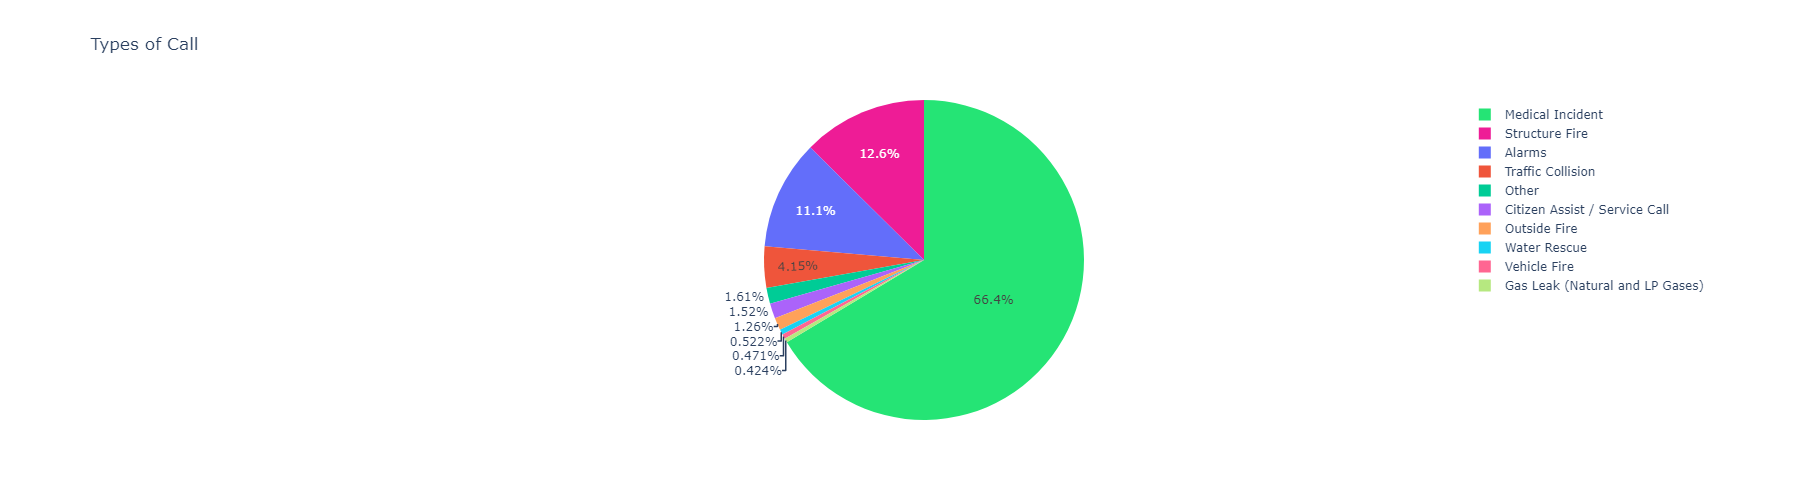

In [18]:
pie_visual = go.Pie(labels=call, values=incident_count, marker=dict(colors=['#25e475', '#ee1c96',]))

layout = go.Layout(title='Types of Call', width=800, height=500)
fig = go.Figure(data=[pie_visual], layout=layout)
iplot(fig)

## Q3 Find out all response or delayed times greater than 5 mins?

1. Rename the column Delay - > ReponseDelayedinMins
2. Returns a new DataFrame
3. Find out all calls where the response time to the fire site was delayed for more than 5 mins

We don't have a column `Delay`, so we need to use 
- ReceivedDtTm
- EntryDtTm
- DispatchDtTm
- ResponseDtTm
- OnSceneDtTm

In [20]:
df_raw.select("IncidentNumber","ReceivedDtTm","EntryDtTm","DispatchDtTm","ResponseDtTm","OnSceneDtTm").show(2,truncate=False)

+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|IncidentNumber|ReceivedDtTm          |EntryDtTm             |DispatchDtTm          |ResponseDtTm          |OnSceneDtTm           |
+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+
|21017645      |02/08/2021 01:00:14 PM|02/08/2021 01:01:36 PM|02/08/2021 01:01:40 PM|02/08/2021 01:03:21 PM|02/08/2021 01:05:44 PM|
|21017596      |02/08/2021 10:54:56 AM|02/08/2021 10:56:50 AM|02/08/2021 10:56:57 AM|02/08/2021 10:57:07 AM|02/08/2021 10:59:34 AM|
+--------------+----------------------+----------------------+----------------------+----------------------+----------------------+
only showing top 2 rows



We could use `OnSeneDtTm-ReceivedDtTm` to evaluate the deplay between a call received by the fire departement and fire fighter on scene. The problem here is they are all in String, we need to convert them into timestamp first.

In [21]:
incident_receive_time_col="ReceivedTime"
incident_on_sene_time_col="OnSeneTime"

In [22]:
date_format="MM/dd/yyyy"
time_format="MM/dd/yyyy hh:mm:ss a"
fire_df1=df_raw.withColumn(incident_receive_time_col,to_timestamp(col("ReceivedDtTm"),time_format)) \
.drop("ReceivedDtTm") \
.withColumn(incident_on_sene_time_col,to_timestamp(col("OnSceneDtTm"),time_format)) \
.drop("OnSceneDtTm") \
.withColumn("CallDateTs",to_timestamp(col("CallDate"),date_format)) \
.drop("CallDate")

In [19]:
fire_df1.select(incident_receive_time_col,incident_on_sene_time_col).show()

+-------------------+-------------------+
|       ReceivedTime|         OnSeneTime|
+-------------------+-------------------+
|2021-02-08 13:00:14|2021-02-08 13:05:44|
|2021-02-08 10:54:56|2021-02-08 10:59:34|
|2021-02-08 10:18:53|2021-02-08 10:27:42|
|2021-02-08 08:50:27|               null|
|2021-02-07 21:18:38|2021-02-07 21:25:11|
|2021-02-07 17:24:48|2021-02-07 17:30:04|
|2021-02-07 15:09:02|2021-02-07 15:11:32|
|2021-02-07 13:07:40|2021-02-07 13:11:29|
|2021-02-07 12:00:39|2021-02-07 12:12:28|
|2021-02-07 05:41:18|2021-02-07 05:46:20|
|2021-02-07 02:11:22|2021-02-07 02:17:16|
|2021-02-06 18:50:12|2021-02-06 18:56:34|
|2021-02-06 06:44:40|2021-02-06 06:57:06|
|2021-02-06 05:33:10|2021-02-06 05:40:11|
|2021-02-06 03:24:29|2021-02-06 03:36:59|
|2021-02-05 17:04:25|               null|
|2021-02-05 08:01:17|2021-02-05 08:13:31|
|2021-02-05 05:22:23|               null|
|2021-02-05 19:29:12|               null|
|2021-02-08 08:09:24|2021-02-08 08:49:44|
+-------------------+-------------

Now we have new problems?
1. You can notice that we have many null values in OnSeneTime, what should we do?
2. How to calculate timestamp difference in minutes?

In [23]:
delay_df=fire_df1.withColumn("Delay",round((unix_timestamp(incident_on_sene_time_col) - unix_timestamp(incident_receive_time_col))/60))

In [24]:
delay_df.select("IncidentNumber","Delay").show()

+--------------+-----+
|IncidentNumber|Delay|
+--------------+-----+
|      21017645|  6.0|
|      21017596|  5.0|
|      21017578|  9.0|
|      21017552| null|
|      21017398|  7.0|
|      21017307|  5.0|
|      21017263|  3.0|
|      21017206|  4.0|
|      21017173| 12.0|
|      21017065|  5.0|
|      21017021|  6.0|
|      21016911|  6.0|
|      21016646| 12.0|
|      21016635|  7.0|
|      21016610| 13.0|
|      21016433| null|
|      21016151| 12.0|
|      21016122| null|
|      21016489| null|
|      21017540| 40.0|
+--------------+-----+
only showing top 20 rows



In [22]:
delayed_response=delay_df.filter(col("Delay")>5)
delayed_response.show(2)

+----------+------+--------------+--------------------+----------+--------------------+--------------------+--------------------+-------------+------------+--------------------+--------------------+--------------------+-------------+-----------------+---------+-----------+----+----------------+--------+-------------+-------+-------------+--------------+--------+--------------------------+----------------------+------------------+--------------------+-------------+--------------------+-------------------+-------------------+-------------------+-----+
|CallNumber|UnitID|IncidentNumber|            CallType| WatchDate|           EntryDtTm|        DispatchDtTm|        ResponseDtTm|TransportDtTm|HospitalDtTm|CallFinalDisposition|       AvailableDtTm|             Address|         City|ZipcodeofIncident|Battalion|StationArea| Box|OriginalPriority|Priority|FinalPriority|ALSUnit|CallTypeGroup|NumberofAlarms|UnitType|Unitsequenceincalldispatch|FirePreventionDistrict|SupervisorDistrict|Neighborhoo

## Q4. Who(zip codes) calls the most?

Let's investigate what zip codes in San Francisco calls the most and what type where they.

- Group them by Zip code
- Count them and display them in descending order
- View them on a map

### Vizulization with folium

Step1: Map geojson file (zip code as index) with the call_zone file (zip code as index) by using . Because the `id (i.e zip)` is string type in geojson file

Step2: To vizualize extra info when hoverup on the map (e.g. the area name, incident number), we need to add information to the geojson file. Check the content of `cp.geojson.data['features']['properties']`. It's a dictionary, all information put in the `properties` can be vizualize by using **GeoJsonTooltip**. 

But Geojson object only accepts string as paramter. So we need to convert the zip column of the mapping file into string to. All the value which we want to add to the `features.properties` must be string type too.

In [25]:
topCallZone=delay_df.groupBy("ZipcodeofIncident").agg(count("IncidentNumber").alias("incident_number")).orderBy(col("incident_number").desc())\
            .withColumnRenamed("ZipcodeofIncident","zip_int") \
.filter(col("zip_int").isNotNull()) \
.withColumn("zip",col("zip_int").cast(StringType()))

In [26]:
topCallZone.show(50)

+-------+---------------+-----+
|zip_int|incident_number|  zip|
+-------+---------------+-----+
|  94102|         697419|94102|
|  94103|         668617|94103|
|  94109|         462364|94109|
|  94110|         461606|94110|
|  94124|         286960|94124|
|  94112|         257640|94112|
|  94115|         242599|94115|
|  94107|         218105|94107|
|  94122|         194590|94122|
|  94133|         192968|94133|
|  94117|         183151|94117|
|  94114|         163557|94114|
|  94118|         161704|94118|
|  94134|         151536|94134|
|  94121|         145369|94121|
|  94132|         132563|94132|
|  94105|         131931|94105|
|  94108|         126418|94108|
|  94116|         117388|94116|
|  94123|         115148|94123|
|  94131|         101189|94131|
|  94111|          92032|94111|
|  94127|          56532|94127|
|  94104|          40528|94104|
|  94130|          36709|94130|
|  94158|          28597|94158|
|  94129|          18852|94129|
+-------+---------------+-----+



In [61]:
topCallZone.printSchema()

root
 |-- zip_int: integer (nullable = true)
 |-- incident_number: long (nullable = false)
 |-- zip: string (nullable = true)
 |-- incident_number_str: string (nullable = false)



In [27]:
call_zone=topCallZone.select("zip","incident_number").toPandas()
call_zone.head()

,zip,incident_number
0,94102,697419
1,94103,668617
2,94109,462364
3,94110,461606
4,94124,286960


In [28]:
# get zip column 

zip_list=call_zone['zip'].tolist()
print(zip_list)

['94102', '94103', '94109', '94110', '94124', '94112', '94115', '94107', '94122', '94133', '94117', '94114', '94118', '94134', '94121', '94132', '94105', '94108', '94116', '94123', '94131', '94111', '94127', '94104', '94130', '94158', '94129']


In [29]:
us_map=pgeocode.Nominatim("US")
address=us_map.query_postal_code("94133")
print(type(address))
print(address)

<class 'pandas.core.series.Series'>
postal_code                                  94133
country_code                                    US
place_name                           San Francisco
state_name                              California
state_code                                      CA
county_name       City and County of San Francisco
county_code                                   75.0
community_name                                None
community_code                                 NaN
latitude                                   37.8002
longitude                                -122.4091
accuracy                                       4.0
Name: 0, dtype: object


In [30]:
print(f"latitude: {address['latitude']}, longitude : {address['longitude']}")

latitude: 37.8002, longitude : -122.4091


In [31]:
# todo dataviz of incident_number on a map with zipcode
sf_district_path="../data/sf_bay_zipcode/sf_bay.shp"

# build the geo-dataframe for generating geojson file
# the index of the geo-dataframe will be used as feature.id of the generated geojson file
districts_full = gpd.read_file(sf_district_path)
districts_used=districts_full[districts_full['zip'].isin(zip_list)]
districts = districts_used[["zip", "geometry"]].set_index("zip")
districts.head()

,geometry
zip,
94108,"POLYGON ((-122.41486 37.79500, -122.41402 37.7..."
94111,"MULTIPOLYGON (((-122.40914 37.80828, -122.4091..."
94112,"POLYGON ((-122.46900 37.70819, -122.46859 37.7..."
94114,"POLYGON ((-122.45415 37.75711, -122.45413 37.7..."
94102,"POLYGON ((-122.42998 37.77886, -122.42902 37.7..."


In [32]:
# Create a base map
sf_map = folium.Map(location=[37.8002,-122.4091], tiles='cartodbpositron', zoom_start=11)

# generate a geojson file based on the geo dataframe
sf_geo=districts.__geo_interface__

# Add a choropleth map to the base map
cp=Choropleth(geo_data=sf_geo,
           name="choropleth",
            # the maping data
           data=call_zone,
            # indicate the column: 1st col is the join key, 2nd is the number  
           columns=["zip","incident_number"],
           key_on="feature.id",
           fill_color='YlGnBu',
           fill_opacity=0.5,
           line_opacity=.1,
           legend_name='911 call counts group by district zip code'
          ).add_to(sf_map)

folium.LayerControl().add_to(sf_map)

# creating a zip indexed version of the dataframe so we can lookup values
call_zone_indexed = call_zone.set_index('zip')
  
# looping thru the geojson object and adding new property()
# the value can be from any resource, you only need to map it with the right index
for s in cp.geojson.data['features']:
    s['properties']['zip_code'] = f"{s['id']}"
    s['properties']['incident_number'] = f"{call_zone_indexed.loc[s['id'],'incident_number']}"

# and finally adding a tooltip/hover to the choropleth's geojson
folium.GeoJsonTooltip(['zip_code', 'incident_number']).add_to(cp.geojson)



# Display the map
sf_map

## Q5. What San Francisco neighborhoods are in the zip codes 94102 and 94103

Let's find out the neighborhoods associated with these two zip codes. In all likelihood, these are some of the contested neighborhood with high reported crimes.

In [31]:
zipcode_col="ZipcodeofIncident"
df_raw.select("NeighborhoodDistrict",zipcode_col).filter((col(zipcode_col)==94102)|(col(zipcode_col)==94103)).distinct().show(truncate=False)

+------------------------------+-----------------+
|NeighborhoodDistrict          |ZipcodeofIncident|
+------------------------------+-----------------+
|Potrero Hill                  |94103            |
|Western Addition              |94102            |
|Tenderloin                    |94102            |
|Nob Hill                      |94102            |
|Castro/Upper Market           |94103            |
|South of Market               |94102            |
|South of Market               |94103            |
|Hayes Valley                  |94103            |
|Financial District/South Beach|94102            |
|Mission Bay                   |94103            |
|Tenderloin                    |94103            |
|Financial District/South Beach|94103            |
|Hayes Valley                  |94102            |
|Mission                       |94103            |
|Mission                       |94102            |
+------------------------------+-----------------+



## Q6. What was the sum of all calls, average, min and max of the response times for calls?

Let's use the built-in Spark SQL functions to compute the sum, avg, min, and max of few columns:

- Number of Total Alarms
- What were the min and max the delay in response time before the Fire Dept arrived at the scene of the call

In [ ]:
delay_df.select("NumberofAlarms","Delay").show()

In [ ]:
delay_df.select(sum("NumberofAlarms"), avg("Delay"),min("Delay"),max("Delay")).show()

## Q7. How many distinct years of data is in the dataset?

In question 3, we already convert the `CallDate (string)` column to `CallDateTs(timestamp)`.
Now we can use the `year()` function to get the year of all `CallDateTs`.


In [ ]:
delay_df.select("CallDateTs").show(1)

In [ ]:
delay_df.select(year("CallDateTs")).distinct().orderBy(year("CallDateTs")).show(30)

## Q8. Which week of the year 2018 had the most calls?

Note: Week 1 is the New Years' week and week 25 is the week of the July 4. Loads of fireworks, so it makes sense the higher number of calls.

In [ ]:
top20Week=delay_df.filter(year("CallDateTs")==2018).groupBy(weekofyear("CallDateTs")).agg(count("IncidentNumber").alias("incident_number")).orderBy(col("incident_number").desc()).limit(20)

In [ ]:
top20Week.show(10)

## Q9 What neighborhoods in San Francisco had the worst response time in 2018?

It appears that the average response time for `Lincoln Park` is more than 13, while `Haight Ashbury` only took 8 mins.

In [ ]:
delay_time_by_neighborhood_desc=delay_df.filter(year("CallDateTs")==2018).groupBy("NeighborhoodDistrict").agg(avg("Delay").alias("avg_delay")).orderBy(col("avg_delay").desc())

In [ ]:
delay_time_by_neighborhood_desc.show(20,False)

In [ ]:
delay_time_by_neighborhood_asc=delay_df.filter(year("CallDateTs")==2018).groupBy("NeighborhoodDistrict").agg(avg("Delay").alias("avg_delay")).orderBy(col("avg_delay").asc())

In [ ]:
delay_time_by_neighborhood_asc.show(20,False)